# Modelo econométrico  para previsão dos gastos da previdência social 
 Utilizando o método SARIMA e Holt Winters

In [165]:
# Importando as principais bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
import numpy as np
import statsmodels.api as sm

In [166]:
# Criando o DF
df= pd.read_csv('valor_despesa_inss.csv', sep=';', encoding='latin1',header=1)

# Drop total
df.drop('Total',axis=1,inplace=True)

In [167]:
# Substituir vírgulas por pontos para converter strings para floats
df.iloc[:, 1:] = df.iloc[:, 1:].replace(',', '.', regex=True).astype(float)

# Transformar o DataFrame no formato longo (melt)
df_long = df.melt(id_vars=['Ano'], var_name='Mês', value_name='Valor')

# Mapeamento dos meses para formato numérico
month_mapping = {
    'Janeiro': '01',
    'Fevereiro': '02',
    'Março': '03',
    'Abril': '04',
    'Maio': '05',
    'Junho': '06',
    'Julho': '07',
    'Agosto': '08',
    'Setembro': '09',
    'Outubro': '10',
    'Novembro': '11',
    'Dezembro': '12'
}

# Mapear os meses e remover linhas inválidas
df_long['Mês'] = df_long['Mês'].map(month_mapping)
df_long = df_long[df_long['Mês'].notna()]

# Criar a coluna 'Data' no formato MM/YYYY
df_long['Data'] = pd.to_datetime(df_long['Ano'].astype(str) + '/' + df_long['Mês'], format='%Y/%m', errors='coerce')

# Remover linhas inválidas onde 'Data' é NaT
df_long = df_long[df_long['Data'].notna()]

# Selecionar as colunas finais
df_final = df_long[['Data', 'Valor']]

In [168]:
# Organizar o DataFrame pela coluna 'Data' em ordem crescente
df_final = df_final.sort_values(by='Data')

# Resetar os índices para manter o DataFrame limpo (opcional)
df_final = df_final.reset_index(drop=True)

In [169]:
df = df_final

# Data vira index
df.set_index('Data', inplace=True)
# Somente valor depois de data 1999-12-01
df = df[df.index >= '2000-01-01']

# Converter a coluna 'Valor' para float
df['Valor'] = df['Valor'].astype(float)

# Arredondar para milhao e duas casas decimais
df['Valor'] = df['Valor'] / 1000000
df['Valor'] = df['Valor'].round(2)

df3 = df.copy()
df5 = df.copy()

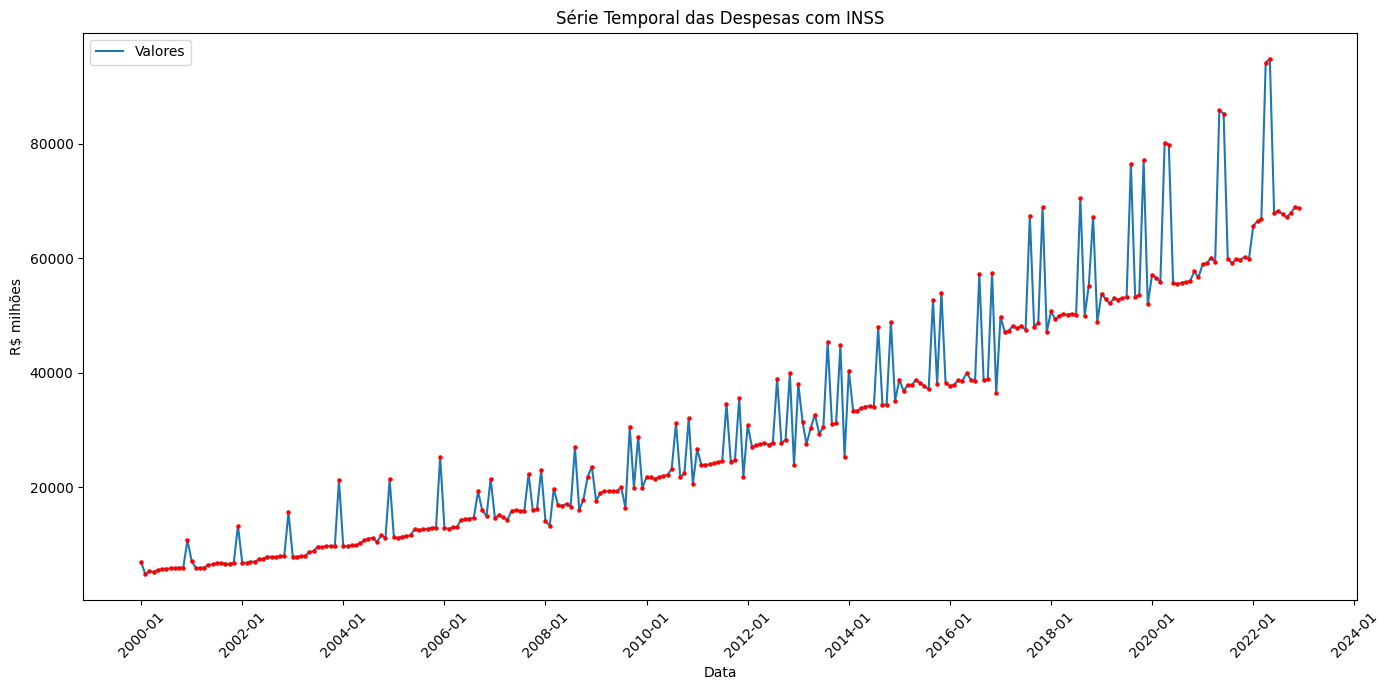

In [170]:
plt.figure(figsize=(14, 7))
sns.lineplot(x=df.index, y=df['Valor'], label='Valores')
plt.scatter(df.index, df['Valor'], color='red', s=5, zorder=5)

# Configurando o formato e os ticks do eixo X
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Intervalo de 2 anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xticks(rotation=45)

# Configurações adicionais
plt.title('Série Temporal das Despesas com INSS')
plt.xlabel('Data')
plt.ylabel('R$ milhões')
plt.tight_layout()
plt.grid(False)
plt.show()


In [171]:
import plotly.express as px
# Criar o gráfico de série temporal interativo
fig = px.line(
    df_final,
    x=df_final.index,
    y='Valor',
    title='Série Temporal dos Gastos com INSS',
    labels={'x': 'Data', 'Valor': 'R$ milhões'},
)

# Ajustar layout para melhor visualização
fig.update_layout(
    xaxis_title='Data',
    yaxis_title='R$ milhões',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
    template='plotly_white'
)

# Exibir o gráfico interativo
fig.show()

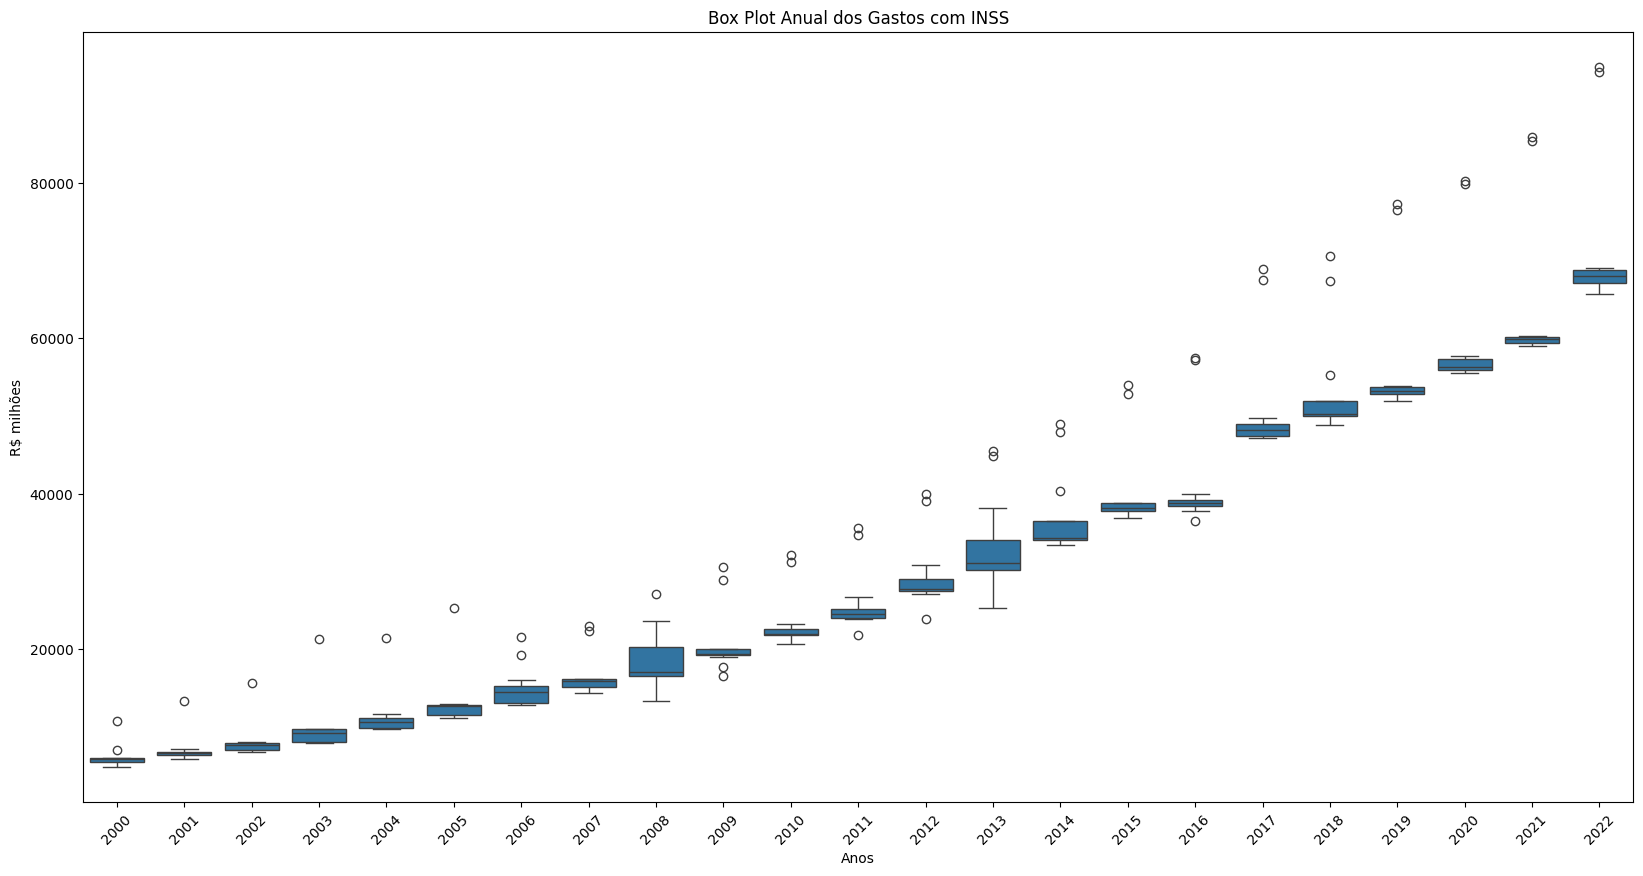

In [172]:
# Criando gráfico Box Plot anual
df['Ano'] = df.index.year


plt.figure(figsize=(20, 10))
sns.boxplot(x='Ano', y='Valor', data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title('Box Plot Anual dos Gastos com INSS')
plt.xlabel('Anos')
plt.ylabel('R$ milhões')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

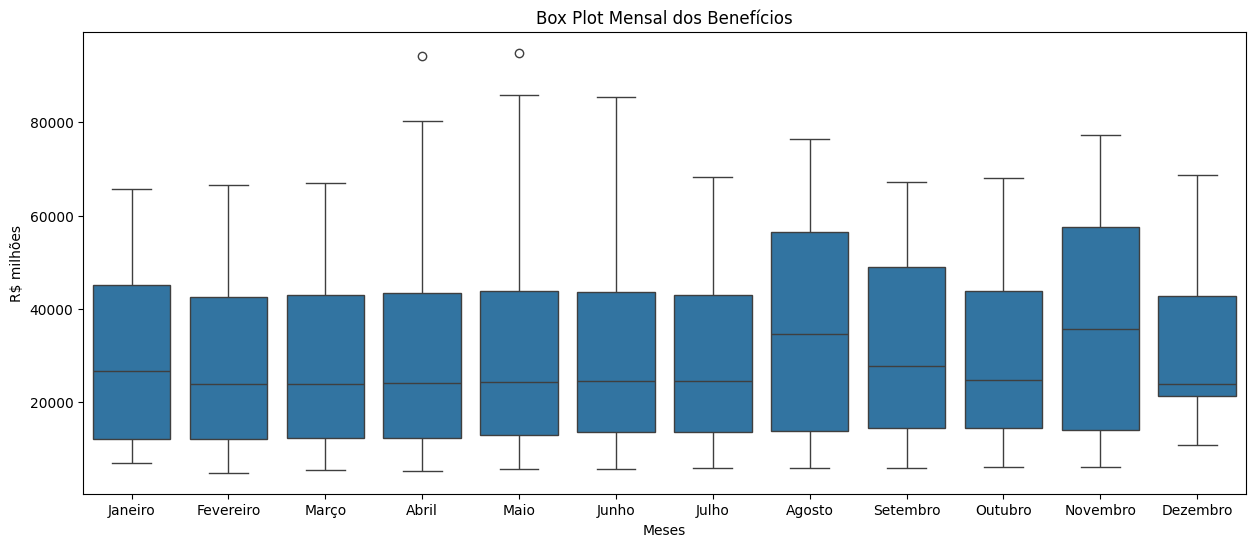

In [173]:
# Analisando efeito sazonal por meio do Box Plot
meses = {1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
         7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

df['Mês'] = df.index.month.map(meses)


plt.figure(figsize=(15, 6))
sns.boxplot(x='Mês', y='Valor', data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title('Box Plot Mensal dos Benefícios')
plt.xlabel('Meses')
plt.ylabel('R$ milhões')
plt.grid(False)
plt.show()

In [174]:
# Decompondo a série para novas análises
serie_temporal = df['Valor']
decomposicao = sm.tsa.seasonal_decompose(serie_temporal, model='additive')

<Figure size 2000x1000 with 0 Axes>

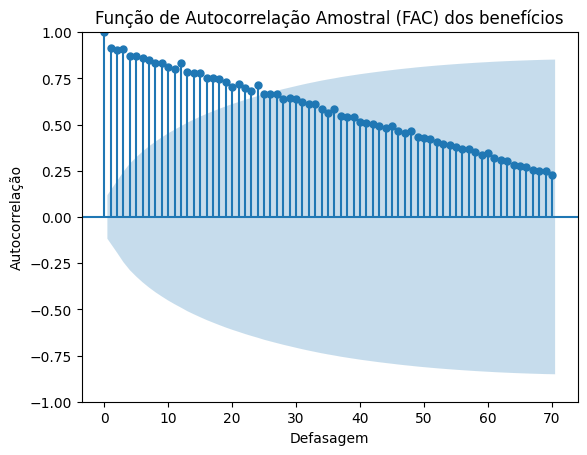

In [175]:
# Criando gráfico de FAC
plt.figure(figsize=(20, 10))
plot_acf(serie_temporal, lags=70)
plt.title('Função de Autocorrelação Amostral (FAC) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação')
plt.grid(False)
plt.show()

<Figure size 2000x1000 with 0 Axes>

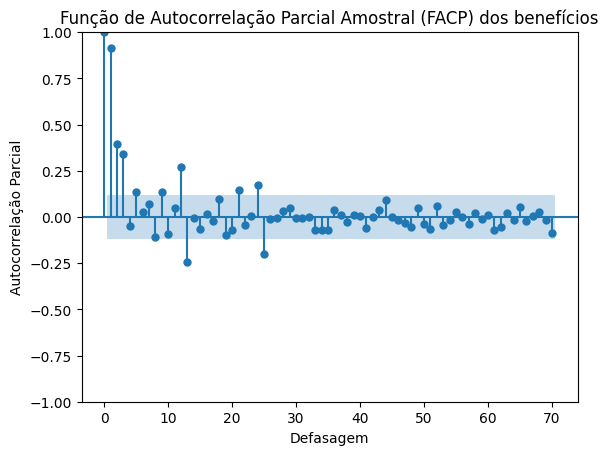

In [176]:
# Criando gráfico FACP
plt.figure(figsize=(20, 10))
plot_pacf(serie_temporal, lags=70)  
plt.title('Função de Autocorrelação Parcial Amostral (FACP) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.show()

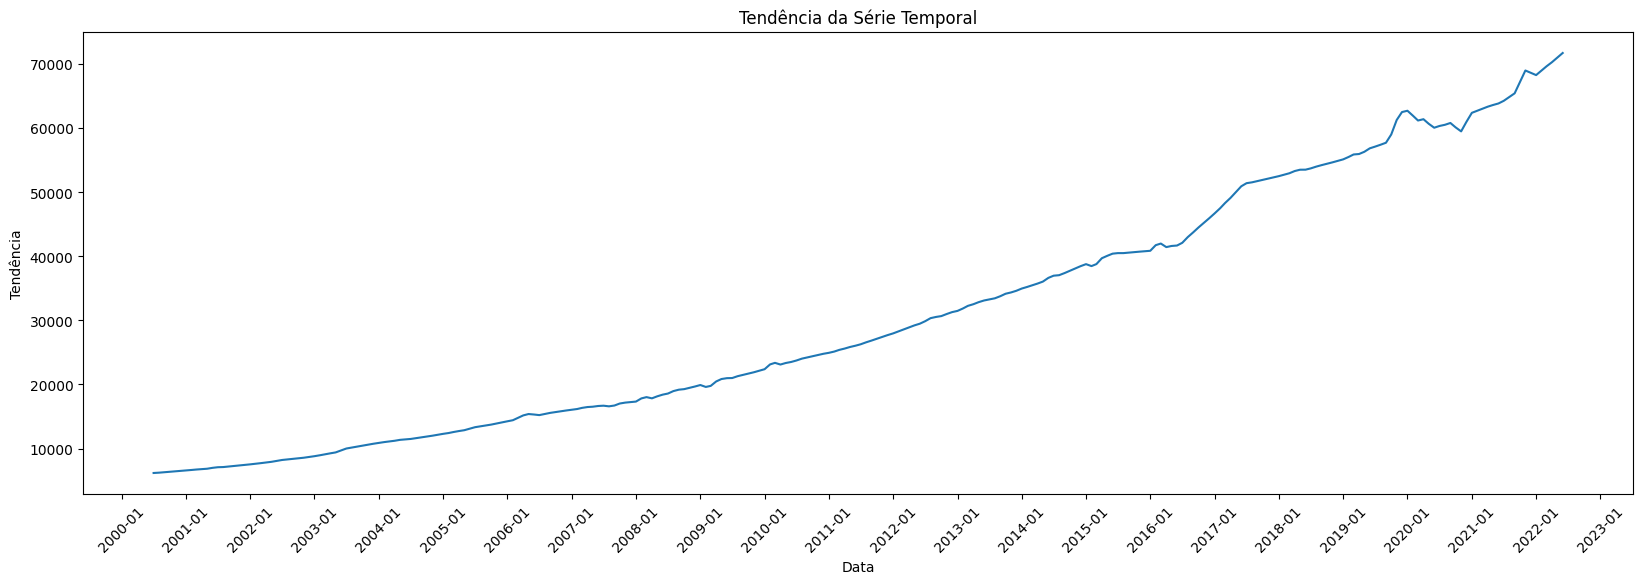

In [177]:
# Gráfico de tendência
plt.figure(figsize=(20, 6))
sns.lineplot(data=decomposicao.trend)
plt.title('Tendência da Série Temporal')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.ylabel('Tendência')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

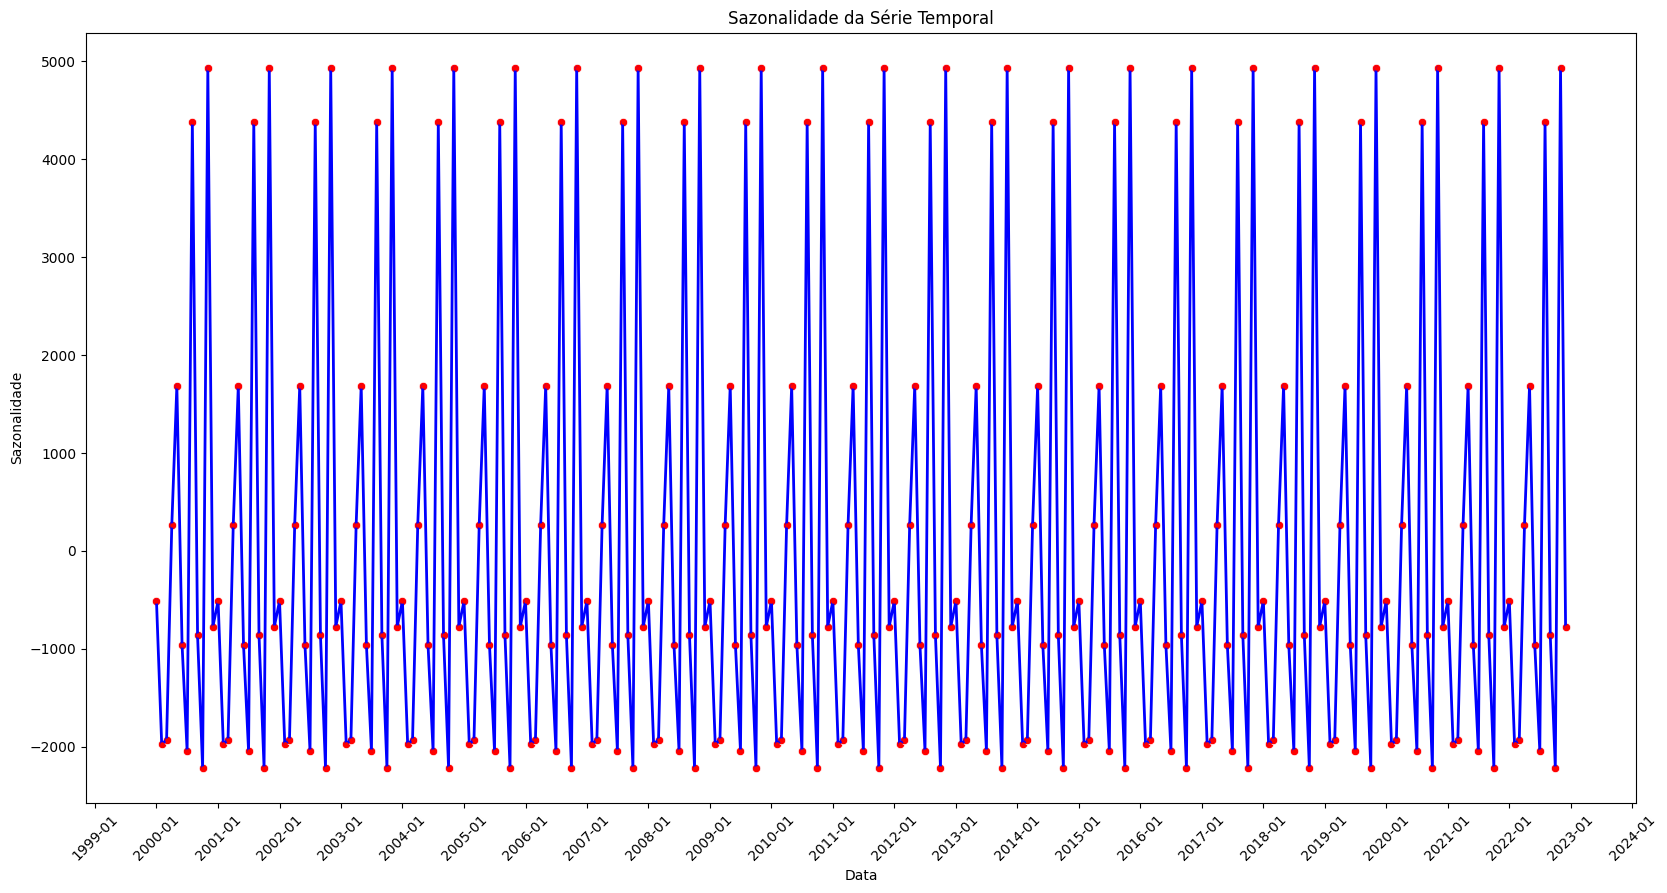

In [178]:
# Gráfico de Sazonalidade
plt.figure(figsize=(20, 10))
sns.lineplot(data=decomposicao.seasonal, color='blue', linewidth=2)
sns.scatterplot(data=decomposicao.seasonal, color='red', marker='o')
plt.scatter(decomposicao.seasonal.index, decomposicao.seasonal.values, color='red', s=5, zorder=5)
plt.title('Sazonalidade da Série Temporal')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.grid(False)
plt.ylabel('Sazonalidade')
plt.xticks(rotation=45)
plt.show()

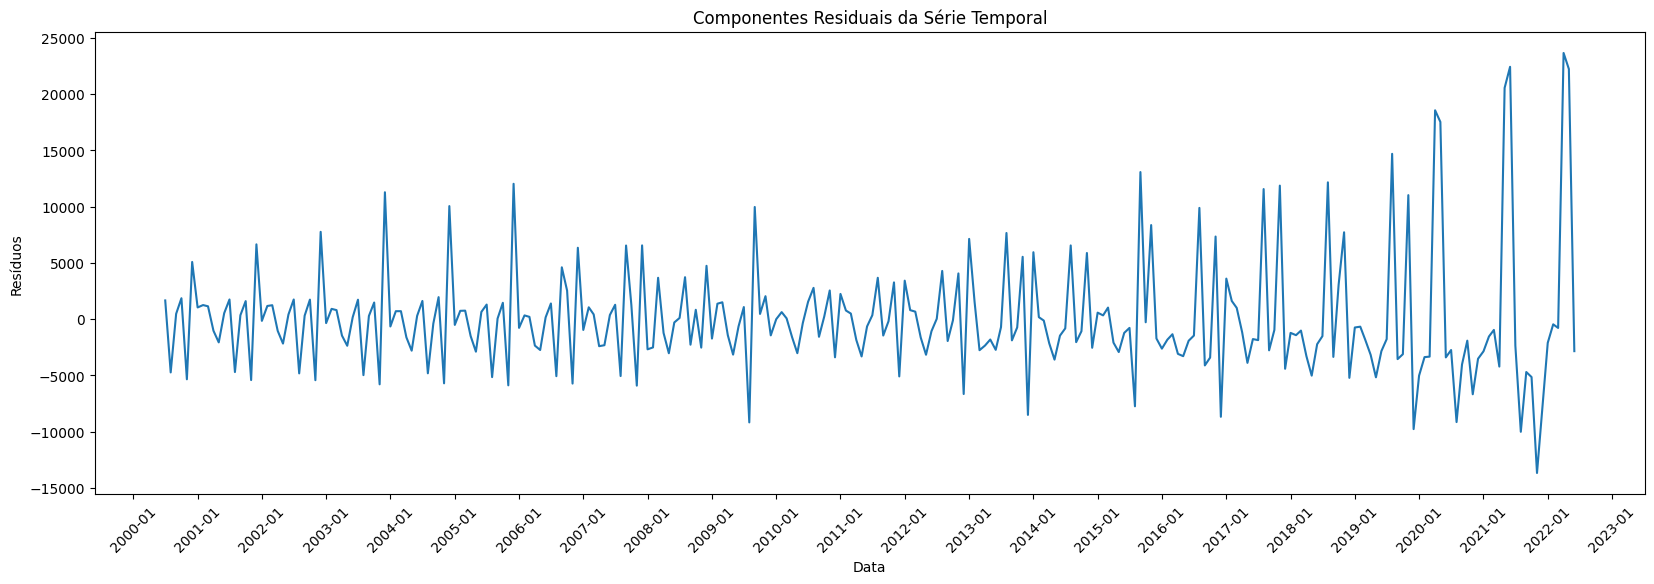

In [179]:
# Gráfico de ruído
plt.figure(figsize=(20,6))
sns.lineplot(data=decomposicao.resid)
plt.title('Componentes Residuais da Série Temporal')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.grid(False)
plt.ylabel('Resíduos')
plt.xticks(rotation=45)
plt.show()


In [180]:
# Realizando teste de hipótese de estacionalidade
result= adfuller(df3)
print(f'P-valor {result[1]}')

P-valor 1.0


In [181]:
# Realizando uma diferenciação na série para corrigir a estacionalidade
df3= df3.diff()
df3=df3.dropna()
result2= adfuller(df3)
print(f'P-valor {result2[1]}')

P-valor 9.22710845293578e-27


<Figure size 2000x600 with 0 Axes>

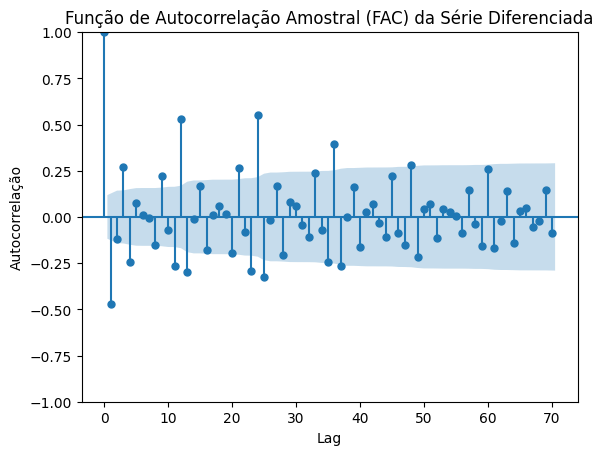

In [182]:
# Novo gráfico FAC
plt.figure(figsize=(20, 6))
plot_acf(df3, lags=70)
plt.title('Função de Autocorrelação Amostral (FAC) da Série Diferenciada')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.grid(False)
plt.show()

<Figure size 2000x1000 with 0 Axes>

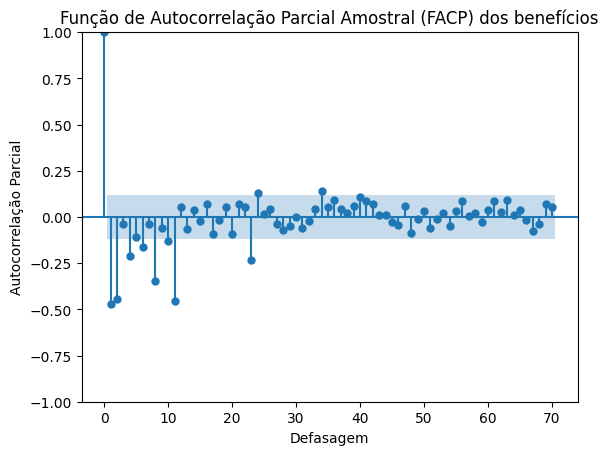

In [183]:
# Novo gráfico FACP
plt.figure(figsize=(20, 10))
plot_pacf(df3, lags=70)  # Define o número de lags para calcular a FACP
plt.title('Função de Autocorrelação Parcial Amostral (FACP) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.grid(False)
plt.show()

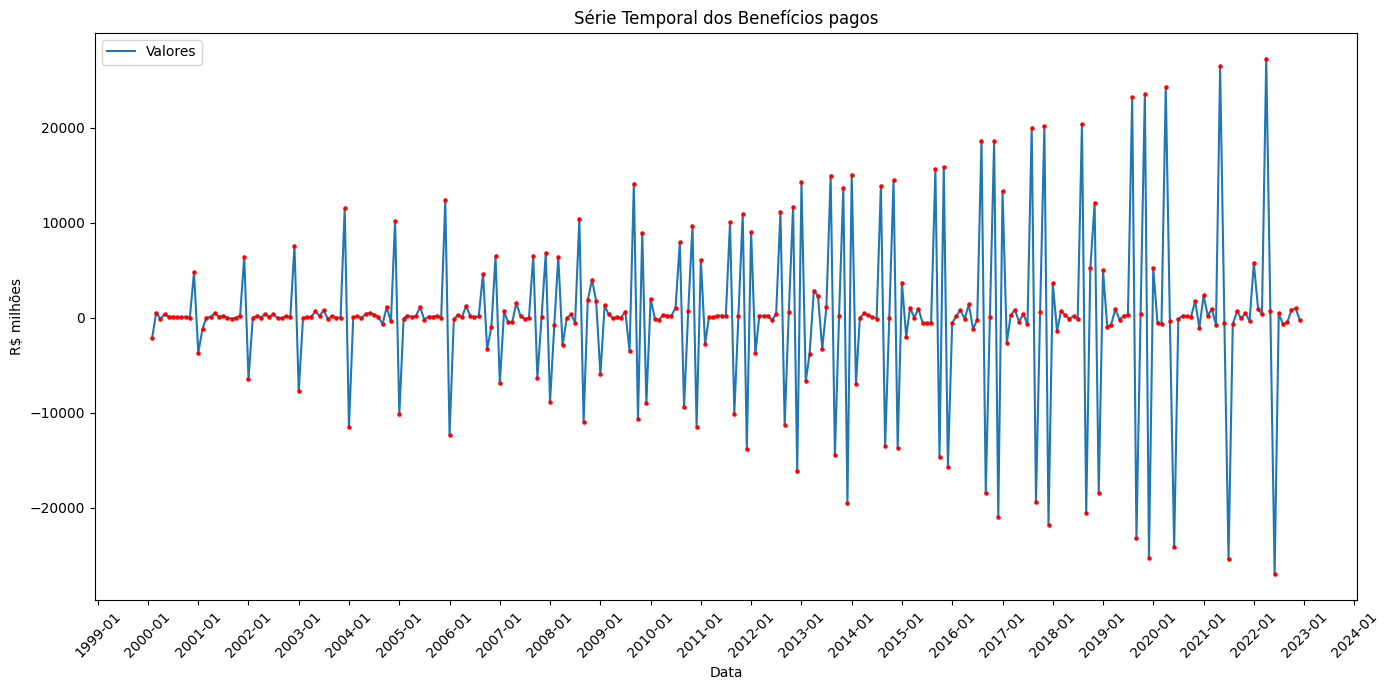

In [184]:
# Novo gráfico de série temporal
plt.figure(figsize=(14, 7))
sns.lineplot(x=df3.index, y=df3['Valor'], label='Valores')
plt.scatter(df3.index, df3['Valor'], color='red', s=5, zorder=5)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xticks(rotation=45)


plt.title('Série Temporal dos Benefícios pagos')
plt.xlabel('Data')
plt.ylabel('R$ milhões')

# Mostrar o gráfico
plt.tight_layout()
plt.grid(False)
plt.show()


In [185]:
# Importando bibliotecas para estimar os erros
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [186]:
# Criando uma função para um parâmetro de erro
def mean_percentage_error(Y,y):
    mpe = np.mean((Y - y )/ Y) * 100
    return mpe

In [187]:
# Função para criar DF com valores dos erros
def teste_erro(serie,previsao):

    MAD = mean_absolute_error(y_true=serie,y_pred=previsao)
    MAPE = mean_absolute_percentage_error(y_true=serie,y_pred=previsao)
    MSD = mean_squared_error(y_true=serie,y_pred=previsao)
    MPE = mean_percentage_error(serie,previsao)

    erros = pd.DataFrame({
        'Metric': ['MAD', 'MAPE', 'MSD', 'MPE'],
        'Value': [MAD, MAPE, MSD, MPE]
    })
    
    return erros

In [189]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

# Ignorar warnings para modelos que não convergem
warnings.filterwarnings("ignore")

# Definir os parâmetros a serem testados
p_values = range(1, 4)  # Ordem autoregressiva
d_values = [1]  # Diferença
q_values = range(1, 3)  # Ordem de média móvel
P_values = range(0, 3)  # Sazonalidade autoregressiva
D_values = range(0, 2)  # Sazonalidade diferença
Q_values = range(0, 3)  # Sazonalidade de média móvel
s = 12  # Período sazonal (mensal = 12)

# Criar todas as combinações de parâmetros
param_combinations = list(product(p_values, d_values, q_values, P_values, D_values, Q_values))

# Lista para armazenar os resultados
results = []

# Total de combinações de parâmetros
total_combinations = len(param_combinations)

# Loop por todas as combinações
for i, (p, d, q, P, D, Q) in enumerate(param_combinations, start=1):
    try:
        # Exibir progresso
        print(f"Testando modelo {i}/{total_combinations} - Parâmetros: (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q})")
        
        # Ajustar o modelo SARIMA
        model = SARIMAX(
            df['Valor'],  # Série temporal original
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        result = model.fit(disp=False)
        
        # Salvar os resultados (AIC, BIC, Log-Likelihood)
        results.append({
            'p': p, 'd': d, 'q': q, 
            'P': P, 'D': D, 'Q': Q,
            'AIC': result.aic,
            'BIC': result.bic,
            'Log-Likelihood': result.llf
        })
    except Exception as e:
        # Ignorar modelos que não convergem
        print(f"Erro no modelo (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}): {e}")

# Criar um DataFrame com os resultados
if results:  # Verificar se há resultados
    results_df = pd.DataFrame(results)
    # Ordenar pelo menor AIC
    results_df = results_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    results_df.head()
else:
    "Nenhum modelo foi ajustado com sucesso."


Testando modelo 1/108 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=0)
Testando modelo 2/108 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=1)
Testando modelo 3/108 - Parâmetros: (p=1, d=1, q=1, P=0, D=0, Q=2)
Testando modelo 4/108 - Parâmetros: (p=1, d=1, q=1, P=0, D=1, Q=0)
Testando modelo 5/108 - Parâmetros: (p=1, d=1, q=1, P=0, D=1, Q=1)
Testando modelo 6/108 - Parâmetros: (p=1, d=1, q=1, P=0, D=1, Q=2)
Testando modelo 7/108 - Parâmetros: (p=1, d=1, q=1, P=1, D=0, Q=0)
Testando modelo 8/108 - Parâmetros: (p=1, d=1, q=1, P=1, D=0, Q=1)
Testando modelo 9/108 - Parâmetros: (p=1, d=1, q=1, P=1, D=0, Q=2)
Testando modelo 10/108 - Parâmetros: (p=1, d=1, q=1, P=1, D=1, Q=0)
Testando modelo 11/108 - Parâmetros: (p=1, d=1, q=1, P=1, D=1, Q=1)
Testando modelo 12/108 - Parâmetros: (p=1, d=1, q=1, P=1, D=1, Q=2)
Testando modelo 13/108 - Parâmetros: (p=1, d=1, q=1, P=2, D=0, Q=0)
Testando modelo 14/108 - Parâmetros: (p=1, d=1, q=1, P=2, D=0, Q=1)
Testando modelo 15/108 - Parâmetros: (p=1, d=1, q=1, P=2,

In [190]:
results_df

,p,d,q,P,D,Q,AIC,BIC,Log-Likelihood
0,1,1,2,2,1,2,4721.719492,4749.430147,-2352.859746
1,1,1,2,0,1,2,4722.408831,4743.191821,-2355.204415
2,1,1,2,1,1,2,4722.788450,4747.035273,-2354.394225
3,2,1,2,2,1,2,4722.967662,4754.142148,-2352.483831
4,2,1,2,0,1,2,4723.793011,4748.039833,-2354.896505
...,...,...,...,...,...,...,...,...,...
103,2,1,2,0,0,0,5529.880305,5547.909315,-2759.940152
104,1,1,2,0,0,0,5533.615885,5548.039094,-2762.807943
105,3,1,1,0,0,0,5534.815893,5552.844904,-2762.407947
106,2,1,1,0,0,0,5559.090539,5573.528426,-2775.545269
